# Input-convex neural networks

* We have designed different network architectures to enforces or promote properties. E.g.,
    + Invariance: PointNet
    + Equivariance: CNNs
    + Better optimizability: ResNet, normalizations.
* Up until now only regression and classification.

Plan:
1. Design networks that are convex in their input (ICNNs) ([Source.](https://arxiv.org/pdf/1609.07152.pdf))
2. Use ICNNs to learn convex probability density functions.

## A reminder on convexity

We want to build a neural network that can only represent convex functions $f:\mathbb{R}^n \to \mathbb{R}$.


````{prf:definition}
:label: convexity_def
We call a function $f:\mathbb{R}^n \to \mathbb{R}$ convex if for all $t\in[0,1]$

$$f(tx + (1-t)y) \le t f(x) + (1-t)f(y) \ \forall x, y.$$
````


````{prf:lemma}
:label: convex_local_minimum_lemma
Any local minimum of a convex function is a global minimum.
````

And we can find it!

Reminder:

````{prf:theorem} Convergence of SGD
:label: sgd_thm

We assume that $f:\mathbb{R}^n\to\mathbb{R}$ has an L-Lipschitz gradient, and is convex. We also assume that we use stochastic gradients $v_k$ from an unbiased estimator with a bounded variance

$$\mbox{Var}(v_k) = \mathbb{E}\|v_k\|_2^2 - \|\mathbb{E}v_k\|_2^2 \le \sigma^2.$$

Then, for any SGD iteration $k$ with step size $t_k=t\le \frac{1}{L}$ we have

$$\mathbb{E} f(\overline x_k) \le f(x^*) + \frac{\|x_0-x^*\|_2^2}{2tk} + t\sigma^2,$$

where $\overline x_k = \frac{1}{k} \sum_{i=1}^{k}x_{i}$ and $x^* = \arg\min_x f(x)$.

Further, we can *expect* to find an $\epsilon/2$ optimal value within

$$k = \frac{(2\sigma^2 + \|x_0-x^*\|_2^2)^2}{\epsilon^2}$$

iterations, by setting $t = \frac{1}{\sqrt{k}}$. Here we assume $\frac{1}{\sqrt{k}} \le \frac{1}{L}$.
````

Therefore we have:

````{prf:theorem} Convergence of Gradient Descent
:label: sgd_thm

We assume that $f:\mathbb{R}^n\to\mathbb{R}$ admits a Taylor expansion, has an L-Lipschitz gradient, and is convex.


Then, for any SGD iteration $k$ with step size $t_k=t\le \frac{1}{L}$ we have

$$f(\overline x_k) \le f(x^*) + \frac{\|x_0-x^*\|_2^2}{2tk},$$

where $\overline x_k = \frac{1}{k} \sum_{i=0}^{k-1}x_{i+1}$ and $x^* = \arg\min_x f(x)$.

Further, we can *expect* to find a $\epsilon/2$ optimal value within

$$k = \frac{\|x_0-x^*\|_2^4}{\epsilon^2}$$

iterations, by setting $t = \frac{1}{\sqrt{k}}$.
````

## Motivation -- is it be useful to learn convex pdfs?
Assume we want to measure some data point $x\in\mathbb{R}$, but our measurement device has Gaussian noisy with the noise standard deviation of $\sigma$. I.e., for the ground truth $x$ we measure a sample from

$$\mathcal{N}(x, \sigma^2) \hat = \frac{1}{\sqrt{2\pi\sigma^2}}\exp -\frac{\left(y-x\right)^2}{2\sigma^2}.$$

If we want to find the most likely $x$ causing our measurement $y$ we want to calculate

$$\arg\max_x p(x|y).$$

Via Bayes theorem we can write

$$p(x|y) = \frac{p(y|x)p(x)}{p(y)} \propto p(y|x)p(x)$$

and since $\log$ is monotonically increasing we can also write

$$\arg\max_x p(x|y) = \arg\min_x -\log p(y|x) - \log p(x)$$
$$=\arg\min_x \frac{1}{2\sigma^2}(y-x)^2 - \log p(x).$$

If we know $-\log p(x)$ and it is convex, then we can solve this problem via gradient descent.


* Problem: One often has samples from $p(x)$, but not the density $p(x)$.
* Idea: Somehow learn a convex approximation of $-\log p(x)$.

## How to build ICNNs

One can use three main properties of convex functions to build ICNNS  (ICNNs) ([Source.](https://arxiv.org/pdf/1609.07152.pdf)).

1. If $g_i:\mathbb{R}^n \to \mathbb{R}$ are convex function and $w_i\ge 0$, then $x \mapsto \sum_i w_ig_i(x)$ is a convex function.
2. If $g:\mathbb{R}^n\to\mathbb{R}$ and $f:\mathbb{R}\to\mathbb{R}$ are convex functions and $f$ is monotonically increasing, then $f\circ g$ is convex.
3. Linear maps are convex.

We can now think about building a layer for an ICNN $f:\mathbb{R}^n\ni x \mapsto f(x)\in\mathbb{R}$. Let $z_i$ be the input of the $i$th layer and $z_0=x$.

* $A_iz_i + b_i$ is convex in $z_i$, for a linear $A_i$.
* $\phi_i(A_iz_i + b_i)$ is convex and monotonically increasing in $z_i$, for the entriwise convex and montonically increasing activation $\phi$ and for $A_i\ge0$ entriwise.
* $\phi_i(A_iz_i + B_ix + b_i)$ is convex in $x$ and convex and monotonically increasing in $z_i$ -- for $B_i$ a general linear mapping.

Therefore we can define a ICNN with entriwise convex outputs via the concatenation layers

$$\phi_i(A_iz_i + B_ix + b_i),$$

where $\phi_i$ is a entriwise convex and monotonically increasing activation. $A_i, B_i$ are matrices, with the entries of $B_i$ being $\ge0$ and $b_i$ being a vector.

## How to learn $-\log p(x)$ from samples?

We assume to have a dataset, $\{x_i\}_i$, of samples $x_i\sim p_X(x)$.

We begin with the simple observation that

$$g(x) := \mathbb{P}(x \text{ was drawn from $p_X$ instead of $p_N$}) = \frac{p_X(x)}{p_X(x) + p_N(x)}$$

If we have such an $f$ and know $p_N$, e.g., we could define it to be a Gaussian, we can compute

$$p_X = \frac{p_N f}{1 - g}$$

and

$$-\log p_X = -\log(p_N) -\log(g) + \log(1 - g) = -\log(p_N) -\log \frac{1}{1/g - 1} = -\log(p_N) + \log (1/g - 1).$$

Or if we assume that the classifer does not include a final sigmoid, i.e., we have $f=\mbox{sigmoid}(g)$ and

$$-\log p_X = -\log(p_N) + \log (1/\mbox{sigmoid}(f) - 1) = -\log(p_N) + \log e^{-f} = -\log(p_N) - f.$$

So, if $-f$ and $-\log(p_N)$ are convex, the whole expression is convex. This is fulfilled if, e.g., $p_N$ is a Gaussian or (on a bounded set) the uniform distribution and $f$ is concave. Architecture-wise, we can represent a concave function via the negative of a convex function. But, how can we train such an $f$?

In theory (and in low dimensions) we can simply train a binary classifier via the BCE to differentiate between samples from the two distributions to get $f$.

## Example

### Train an ICNN to fit $-\log p$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

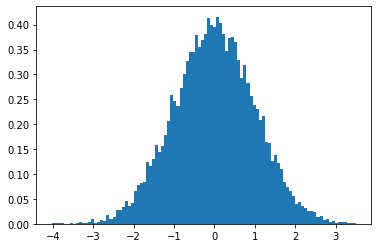

In [2]:
def get_samplesX(n):
    x = torch.randn(n)
    return x


xs = get_samplesX(16384)

plt.hist(xs.numpy(), density=True, bins=100)
plt.show()

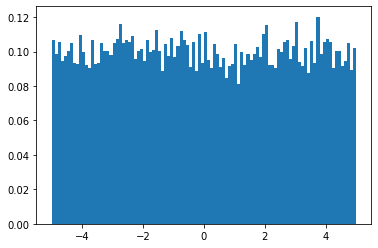

In [3]:
def get_samplesN(n):
    η = 10 * torch.rand(n) - 5
    return η


ηs = get_samplesN(16384)

plt.hist(ηs.numpy(), density=True, bins=100)
plt.show()

In [4]:
def get_training_batch(n_half):
    xs = get_samplesX(n_half)
    ηs = get_samplesN(n_half)

    xs = torch.cat([xs, ηs]).view(-1, 1)
    ys = torch.zeros_like(xs)
    ys[:n_half] = 1.

    return xs, ys

In [5]:
class ICNNLayer(torch.nn.Module):
    def __init__(self, x_dim, input_dim, output_dim, standard_act=True):
        super().__init__()
        self.A = torch.nn.Linear(input_dim, output_dim, bias=False)
        self.B = torch.nn.Linear(x_dim, output_dim)

        if standard_act:
            self.act = torch.nn.LeakyReLU(negative_slope=.2)
        else:
            self.act = torch.nn.Identity()#torch.nn.Sigmoid()


    def forward(self, x, z):
        with torch.no_grad():
            self.A.weight.clamp_(0)

        Az = self.A(z)
        Bx = self.B(x)

        return self.act(Az + Bx)


class ICNN(torch.nn.Module):
    def __init__(self, x_dim=1, width=16):
        super().__init__()
        self.width = width

        self.layer0 = ICNNLayer(x_dim, width, width)
        self.layer1 = ICNNLayer(x_dim, width, width)
        self.layer2 = ICNNLayer(x_dim, width, width)
        self.layer3 = ICNNLayer(x_dim, width, 1, standard_act=False)

    def forward(self, x):
        z = torch.zeros(len(x), self.width, dtype=x.dtype, device=x.device)

        z = self.layer0(x, z)
        z = self.layer1(x, z)
        z = self.layer2(x, z)
        z = self.layer3(x, z)

        return z


class OurDensityModel(ICNN):
    def __init__(self, x_dim=1, width=128):
        super().__init__(x_dim=x_dim, width=width)


    def forward(self, x):
        fs = -super().forward(x)
        minus_log_ps = - torch.log(torch.ones(1)/10) - fs
        ps = torch.exp(-minus_log_ps)
        return fs, minus_log_ps, ps

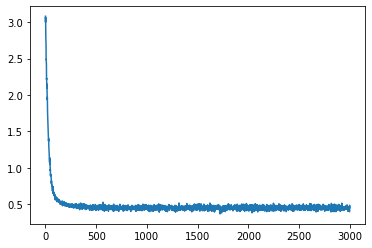

In [6]:
model = OurDensityModel()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.BCEWithLogitsLoss()

losses = []

for _ in range(3000):
    xs, ys = get_training_batch(256)
    fs, minus_log_ps, ps = model(xs)

    loss = criterion(fs, ys)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


plt.plot(losses)
plt.show()

In [7]:
def get_np(xs):
    return xs.detach().numpy()

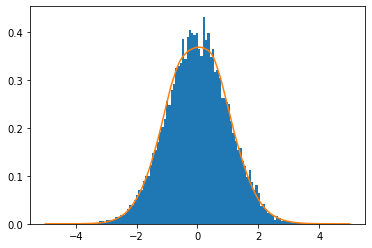

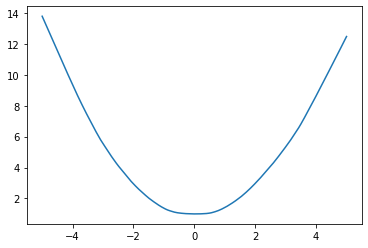

In [8]:
model.eval()

xs = torch.linspace(-5, 5, 1000).view(-1, 1)
fs, minus_log_ps, ps = model(xs)

xs = get_np(xs)
ps = get_np(ps)
minus_log_ps = get_np(minus_log_ps)

plt.hist(get_np(get_samplesX(16384)), density=True, bins=100)
plt.plot(xs, ps)
plt.show()

plt.plot(xs, minus_log_ps)
plt.show()

### Find sample with maximum probability

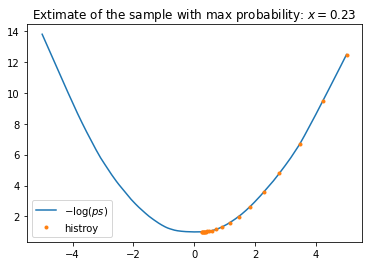

In [9]:
x = 5 * torch.ones(1, 1)
x.requires_grad_()
optimizer = torch.optim.SGD({x}, lr=.2)

x_history = []
y_history = []

for _ in range(20):
    _, minus_log_ps, _ = model(x)

    x_history.append(x.item())
    y_history.append(minus_log_ps.item())

    optimizer.zero_grad()
    minus_log_ps.backward()
    optimizer.step()

plt.title(rf"Extimate of the sample with max probability: $x={x.item():.2}$")
plt.plot(xs, -np.log(ps), label=r"$-\log(ps)$")
plt.plot(x_history, y_history, ".", label="histroy")
plt.legend()
plt.show()

## Exercises
* Assume $g$ and $f$ are sufficiently smooth convex functions and let $f$ be monotonically increasing. Look up the definiton of convexity based on the Hessian and prove that $f\circ g$ is convex.
* Use the above implemented ICNN to implement the reconstruction example in the motivation.